# ATSSB_Prob510_REGARMA_Temperature

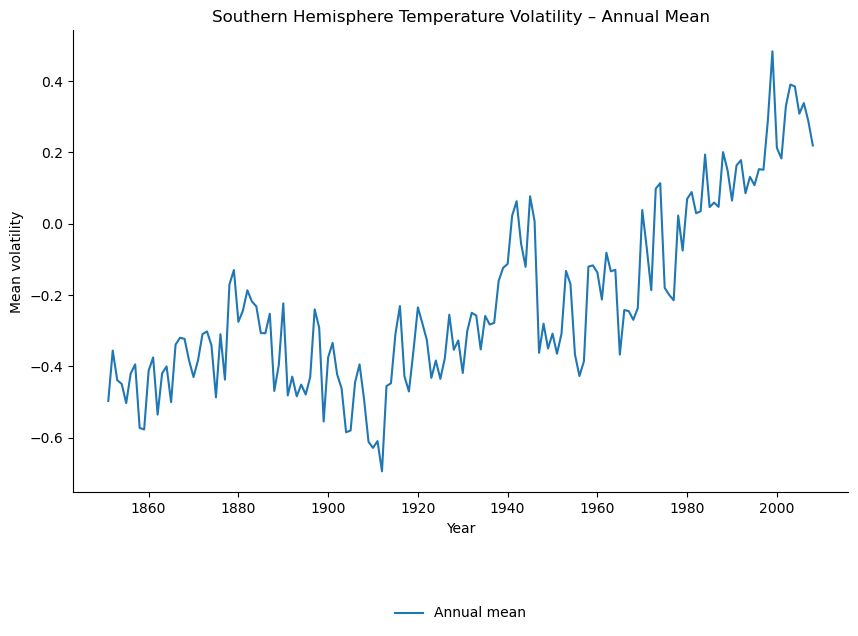

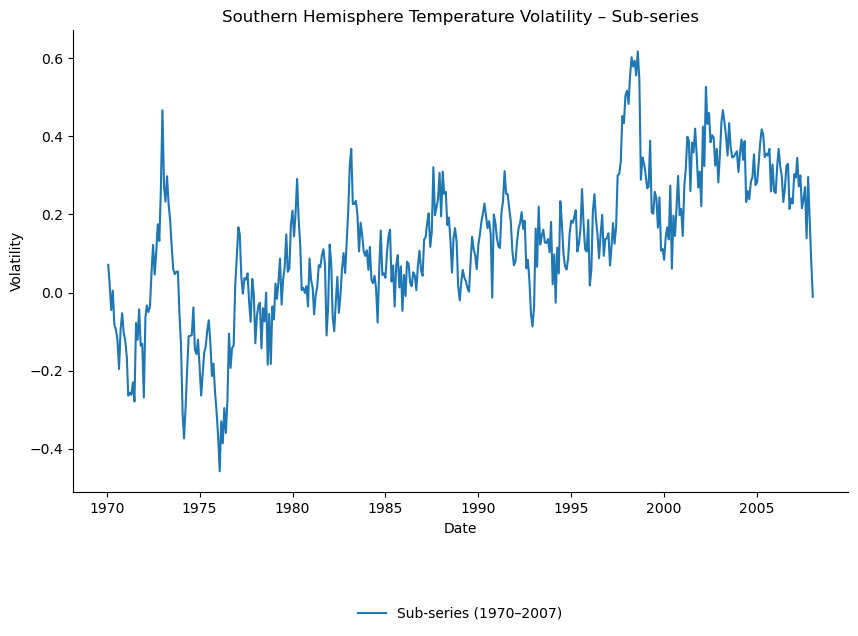


===== HSR (OLS) RESULTS =====
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     260.6
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           4.82e-76
Time:                        11:15:24   Log-Likelihood:                 299.45
No. Observations:                 456   AIC:                            -592.9
Df Residuals:                     453   BIC:                            -580.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1235

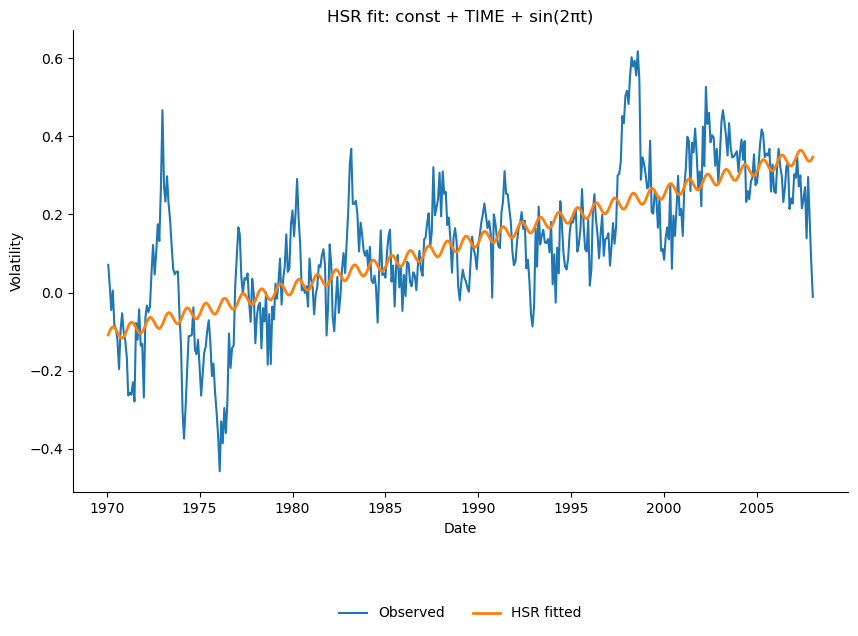

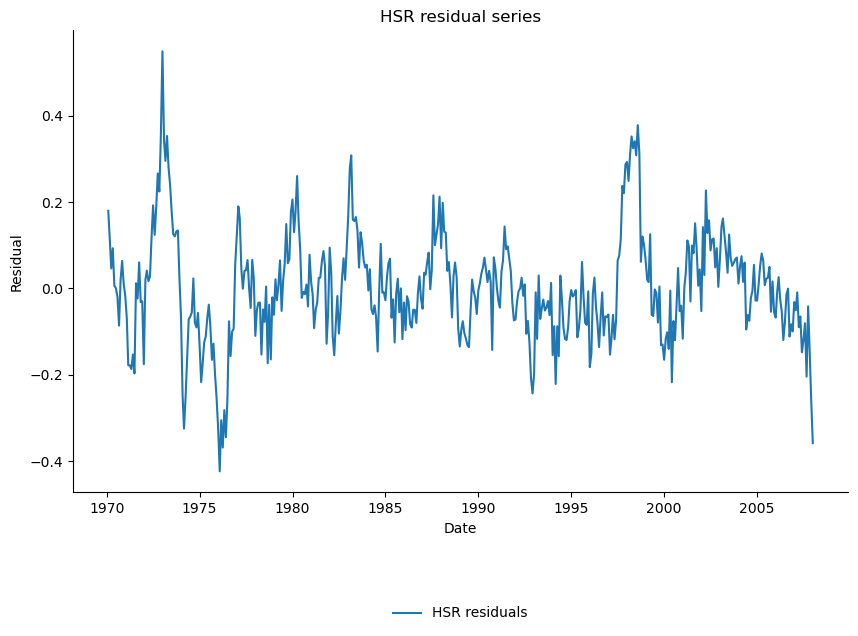

/var/folders/pk/sxdc5n5x6mb322grbvxz_nm40000gp/T/ipykernel_59855/1728767777.py:158: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(hsr_resid.values, regression="c", nlags="auto")



===== KPSS on HSR residuals =====
KPSS stat: 0.043656 | p-value: 0.100000 | lags: 11
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


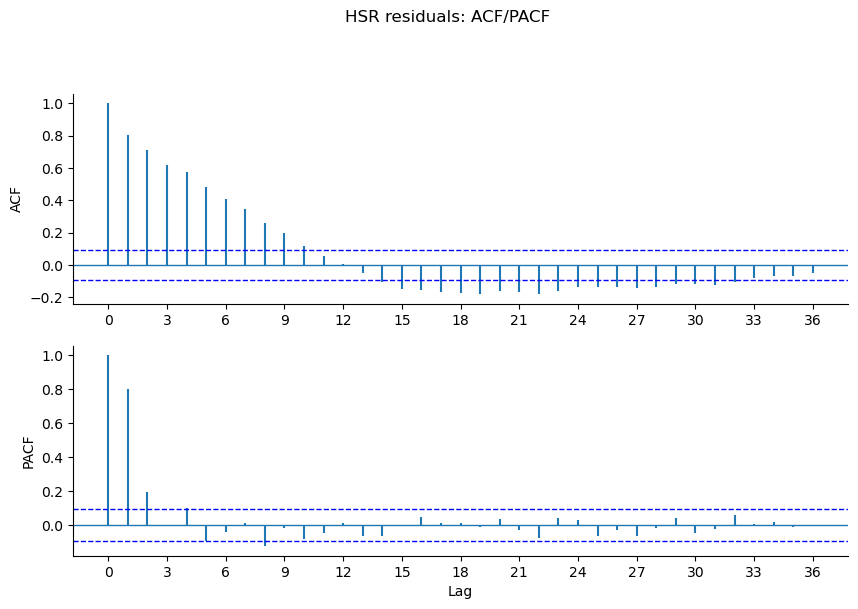


===== AR(2) on HSR residuals =====
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  456
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 553.616
Date:                Sat, 21 Feb 2026   AIC                          -1101.233
Time:                        11:15:25   BIC                          -1088.865
Sample:                             0   HQIC                         -1096.361
                                - 456                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6530      0.043     15.184      0.000       0.569       0.737
ar.L2          0.2041      0.045      4.527      0.000       0.116       0.292
sigma2         0

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


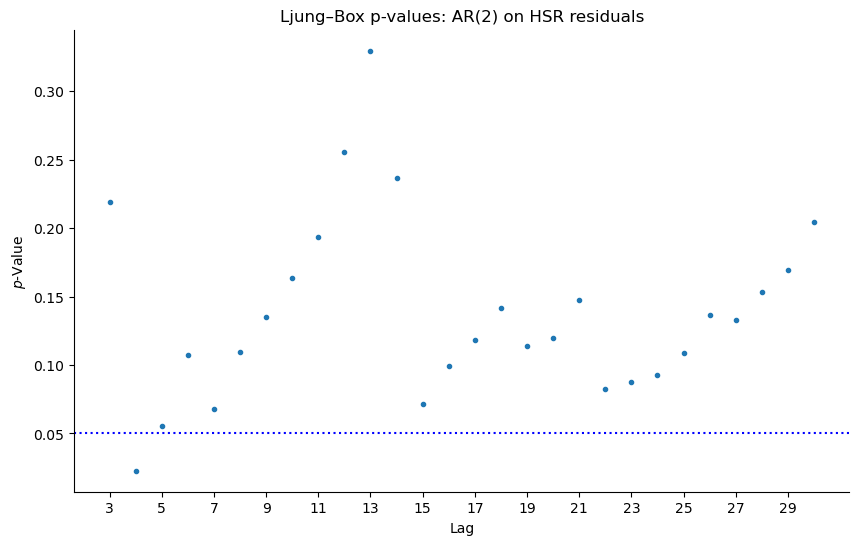


===== ARMA(2,[4]) on HSR residuals =====
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  456
Model:               ARIMA(2, 0, [4])   Log Likelihood                 557.632
Date:                Sat, 21 Feb 2026   AIC                          -1107.264
Time:                        11:15:25   BIC                          -1090.775
Sample:                             0   HQIC                         -1100.769
                                - 456                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6574      0.043     15.359      0.000       0.573       0.741
ar.L2          0.1718      0.047      3.664      0.000       0.080       0.264
ma.L4     

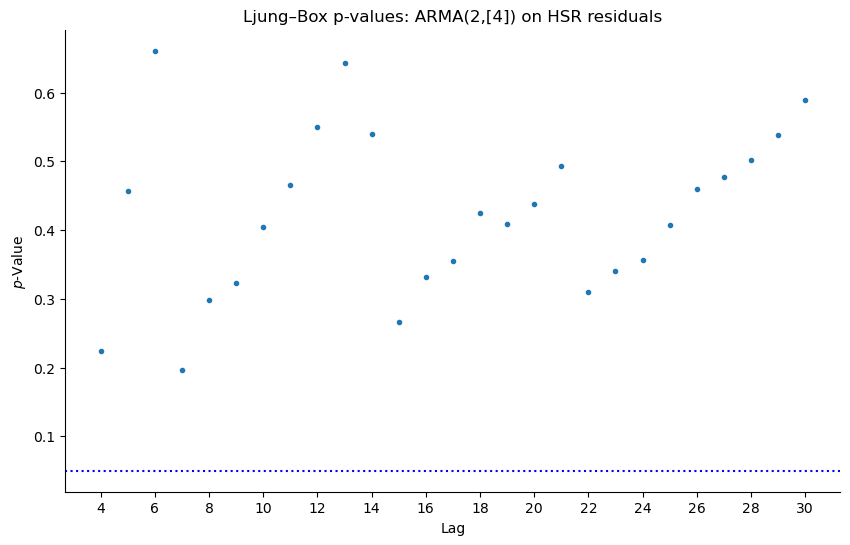


===== REGARMA (HSR + ARMA(2,[4])) =====
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  456
Model:               ARIMA(2, 0, [4])   Log Likelihood                 557.934
Date:                Sat, 21 Feb 2026   AIC                          -1101.868
Time:                        11:15:25   BIC                          -1073.011
Sample:                             0   HQIC                         -1090.501
                                - 456                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1213      0.022      5.456      0.000       0.078       0.165
x1             0.1217      0.021      5.857      0.000       0.081       0.162
x2         

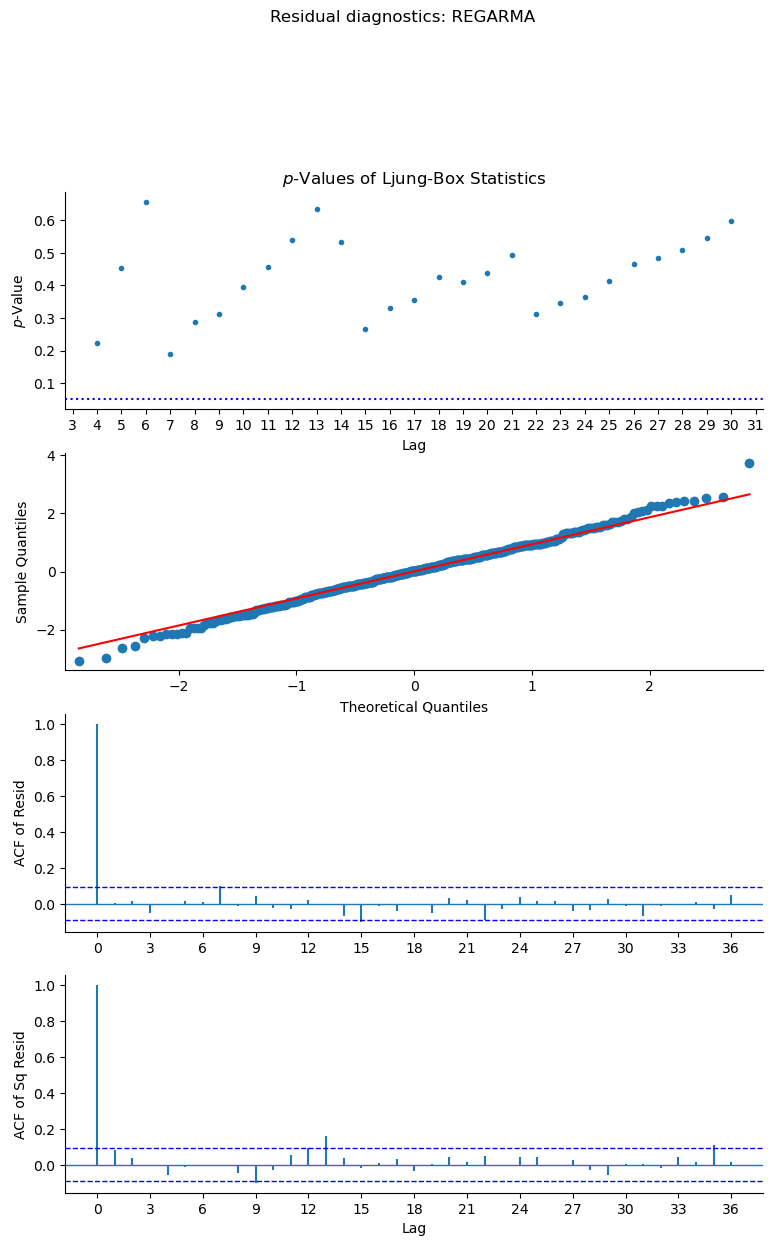


All charts saved to: /Users/danielpele/Documents/Chapter5_Quantlets/ATSSB_Prob510_REGARMA_Temperature/ATSSB_Prob510_figs


In [5]:
# ==========================================================
# ATSSB – Chapter 5, Problem 5.10 (FULL, book-faithful)
# Southern Hemisphere temperature volatility (1970-01 to 2007-12)
# Pipeline:
#  (1) load data from PythonTsa datadir
#  (2) annual mean plot (trend)
#  (3) extract sub-series (1970–2007) + plot
#  (4) HSR (harmonic seasonal regression) via OLS
#      - confirm residual stationarity (KPSS p>0.1)
#      - ACF/PACF of residuals
#  (5) Fit AR(2) to HSR residuals, reject via Ljung–Box (p<0.05 at lag 4)
#  (6) Fit ARMA(2,[4]) to HSR residuals, validate via Ljung–Box
#  (7) Fit REGARMA: ARMA(2,[4]) with exog (HSR regressors), validate diagnostics
#
# OUTPUT (transparent, legend outside bottom, no grid):
#  - yearly_mean.png/.pdf
#  - exts_series.png/.pdf
#  - hsr_fit.png/.pdf
#  - hsr_resid_series.png/.pdf
#  - hsr_resid_acf_pacf.png/.pdf
#  - ar2_lb_pvalues.png/.pdf
#  - arma204_lb_pvalues.png/.pdf
#  - regarma_resid_diagnostics.png/.pdf
# ==========================================================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA

from PythonTsa.plot_acf_pacf import acf_pacf_fig
from PythonTsa.LjungBoxtest import plot_LB_pvalue
from PythonTsa.ModResidDiag import plot_ResidDiag
from PythonTsa.datadir import getdtapath

# -----------------------------
# Global plotting style
# -----------------------------
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.facecolor": "none",
    "axes.facecolor": "none",
    "savefig.transparent": True,
    "axes.grid": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False
})

FIG_DIR = Path("ATSSB_Prob510_figs")
FIG_DIR.mkdir(exist_ok=True)

def legend_bottom(ax=None, y=-0.18):
    ax = ax or plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        ax.legend(loc="upper center", bbox_to_anchor=(0.5, y), ncol=min(3, len(labels)))

def savefig(stem):
    fig = plt.gcf()
    fig.savefig(FIG_DIR / f"{stem}.png", dpi=300, transparent=True, bbox_inches="tight")
    fig.savefig(FIG_DIR / f"{stem}.pdf", transparent=True, bbox_inches="tight")

# ==========================================================
# (1) Load Southern Hemisphere temperature volatility
# ==========================================================
dtapath = getdtapath()
tem = pd.read_csv(dtapath + "Southtemperature.txt", header=None, sep=r"\s+")

# Book-faithful flatten (row-wise)
temts = pd.concat([tem.loc[0], tem.loc[1]], ignore_index=True)
for i in range(2, len(tem)):
    temts = pd.concat([temts, tem.loc[i]], ignore_index=True)

# Monthly index starting 1850
dates = pd.date_range("1850-01-31", periods=len(temts), freq="ME")
temts.index = dates
temts = pd.Series(temts.values, index=dates, name="tem_vol")

# ==========================================================
# (2) Annual mean plot to reveal trend
# ==========================================================
ytemts = temts.resample("YE").mean()

plt.plot(ytemts.index, ytemts.values, label="Annual mean")
plt.title("Southern Hemisphere Temperature Volatility – Annual Mean")
plt.xlabel("Year")
plt.ylabel("Mean volatility")
legend_bottom(y=-0.22)
savefig("yearly_mean")
plt.show()

# ==========================================================
# (3) Extract sub-series: 1970-01 to 2007-12 and plot
# ==========================================================
exts = temts["1970-01-31":"2007-12-31"].copy()

plt.plot(exts.index, exts.values, label="Sub-series (1970–2007)")
plt.title("Southern Hemisphere Temperature Volatility – Sub-series")
plt.xlabel("Date")
plt.ylabel("Volatility")
legend_bottom(y=-0.22)
savefig("exts_series")
plt.show()

# ==========================================================
# (4) Harmonic Seasonal Regression (HSR) – book-faithful simplified version
#     They ultimately use regressors: const + TIME + SIN(2π t)
# ==========================================================
# Build monthly t-grid exactly as in book: 1970 + j/12
# (using calendar months, faithful and dimension-safe)
pi = math.pi
n = len(exts)
pidx = pd.period_range("1970-01", "2007-12", freq="M")
assert len(pidx) == n, f"Expected {n} months; got {len(pidx)}"

# tim = year + (month-1)/12
tim = np.array([p.year + (p.month - 1)/12.0 for p in pidx], dtype=float)

TIME = (tim - np.mean(tim)) / np.sqrt(np.var(tim))  # book uses sqrt(var)
SIN1 = np.sin(2 * pi * 1 * tim)

X = np.column_stack((TIME, SIN1))
X = sm.add_constant(X)

hsr = sm.OLS(exts.values, X).fit()
print("\n===== HSR (OLS) RESULTS =====")
print(hsr.summary())

hsr_fitted = pd.Series(hsr.fittedvalues, index=exts.index, name="hsr_fitted")
hsr_resid  = pd.Series(hsr.resid, index=exts.index, name="hsr_resid")

# Plot observed vs HSR fit
plt.plot(exts.index, exts.values, label="Observed")
plt.plot(hsr_fitted.index, hsr_fitted.values, label="HSR fitted", linewidth=2)
plt.title("HSR fit: const + TIME + sin(2πt)")
plt.xlabel("Date")
plt.ylabel("Volatility")
legend_bottom(y=-0.22)
savefig("hsr_fit")
plt.show()

# Residual series plot
plt.plot(hsr_resid.index, hsr_resid.values, label="HSR residuals")
plt.title("HSR residual series")
plt.xlabel("Date")
plt.ylabel("Residual")
legend_bottom(y=-0.22)
savefig("hsr_resid_series")
plt.show()

# KPSS stationarity test on residuals (require p > 0.1 in the narrative)
kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(hsr_resid.values, regression="c", nlags="auto")
print("\n===== KPSS on HSR residuals =====")
print(f"KPSS stat: {kpss_stat:.6f} | p-value: {kpss_p:.6f} | lags: {kpss_lags}")
print(f"Critical values: {kpss_crit}")

# ACF/PACF on residuals
acf_pacf_fig(hsr_resid.values, both=True, lag=36)
plt.suptitle("HSR residuals: ACF/PACF", y=1.02)
savefig("hsr_resid_acf_pacf")
plt.show()

# ==========================================================
# (5) Fit AR(2) on HSR residuals; reject via Ljung–Box (p < 0.05 at lag 4)
# ==========================================================
ar2 = ARIMA(hsr_resid.values, order=(2, 0, 0), trend="n").fit()
print("\n===== AR(2) on HSR residuals =====")
print(ar2.summary())

plot_LB_pvalue(ar2.resid, noestimatedcoef=2, nolags=30)
plt.title("Ljung–Box p-values: AR(2) on HSR residuals")
savefig("ar2_lb_pvalues")
plt.show()

# ==========================================================
# (6) Fit ARMA(2,[4]) on HSR residuals; validate via Ljung–Box
# ==========================================================
arma_204 = ARIMA(hsr_resid.values, order=(2, 0, [4]), trend="n").fit()
print("\n===== ARMA(2,[4]) on HSR residuals =====")
print(arma_204.summary())

plot_LB_pvalue(arma_204.resid, noestimatedcoef=3, nolags=30)
plt.title("Ljung–Box p-values: ARMA(2,[4]) on HSR residuals")
savefig("arma204_lb_pvalues")
plt.show()

# ==========================================================
# (7) REGARMA: ARMA(2,[4]) with exog (TIME, SIN1), trend='c' (book-faithful)
#     IMPORTANT: exog must NOT include a constant when trend='c'
# ==========================================================
Y_exog = np.column_stack((TIME, SIN1))  # no constant column here
regarma = ARIMA(exts.values, order=(2, 0, [4]), exog=Y_exog, trend="c").fit()
print("\n===== REGARMA (HSR + ARMA(2,[4])) =====")
print(regarma.summary())

# Final residual diagnostics (PythonTsa plot_ResidDiag draws a figure but returns None)
plot_ResidDiag(regarma.resid, noestimatedcoef=3, nolags=30, lag=36)
plt.suptitle("Residual diagnostics: REGARMA", y=1.02)
savefig("regarma_resid_diagnostics")
plt.show()

print(f"\nAll charts saved to: {FIG_DIR.resolve()}")